<a href="https://colab.research.google.com/github/jerry2eden/09-water-salinity/blob/master/WaterSalinityPipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing important libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict

In [ ]:
# Note: 50% of the original dataset were randomly selected for analysis. view the Cst_Cnt field to see the randomness

raw_bottle= pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/bottle.csv")
raw_bottle.head(3)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (47,73) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Cst_Cnt,Btl_Cnt,Sta_ID,Depth_ID,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,Oxy_µmol/Kg,BtlNum,RecInd,T_prec,T_qual,S_prec,S_qual,P_qual,O_qual,SThtaq,O2Satq,ChlorA,Chlqua,Phaeop,Phaqua,PO4uM,PO4q,SiO3uM,SiO3qu,NO2uM,NO2q,NO3uM,NO3q,NH3uM,NH3q,C14As1,C14A1p,C14A1q,C14As2,C14A2p,C14A2q,DarkAs,DarkAp,DarkAq,MeanAs,MeanAp,MeanAq,IncTim,LightP,R_Depth,R_TEMP,R_POTEMP,R_SALINITY,R_SIGMA,R_SVA,R_DYNHT,R_O2,R_O2Sat,R_SIO3,R_PO4,R_NO3,R_NO2,R_NH4,R_CHLA,R_PHAEO,R_PRES,R_SAMP,DIC1,DIC2,TA1,TA2,pH2,pH1,DIC Quality Comment
0,1,1,054.0 056.0,19-4903CR-HY-060-0930-05400560-0000A-3,0,10.50,33.440,NaN,25.649,NaN,NaN,NaN,3,1.0,NaN,2.0,NaN,9.0,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,0.0,10.50,10.50,33.440,25.64,233.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,054.0 056.0,19-4903CR-HY-060-0930-05400560-0008A-3,8,10.46,33.440,NaN,25.656,NaN,NaN,NaN,3,2.0,NaN,2.0,NaN,9.0,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,8.0,10.46,10.46,33.440,25.65,232.5,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,054.0 056.0,19-4903CR-HY-060-0930-05400560-0010A-7,10,10.46,33.437,NaN,25.654,NaN,NaN,NaN,7,2.0,NaN,3.0,NaN,9.0,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,10.0,10.46,10.46,33.437,25.65,232.8,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# displaying columns for feature engineering

raw_bottle.columns

Index(['Cst_Cnt', 'Btl_Cnt', 'Sta_ID', 'Depth_ID', 'Depthm', 'T_degC',
       'Salnty', 'O2ml_L', 'STheta', 'O2Sat', 'Oxy_µmol/Kg', 'BtlNum',
       'RecInd', 'T_prec', 'T_qual', 'S_prec', 'S_qual', 'P_qual', 'O_qual',
       'SThtaq', 'O2Satq', 'ChlorA', 'Chlqua', 'Phaeop', 'Phaqua', 'PO4uM',
       'PO4q', 'SiO3uM', 'SiO3qu', 'NO2uM', 'NO2q', 'NO3uM', 'NO3q', 'NH3uM',
       'NH3q', 'C14As1', 'C14A1p', 'C14A1q', 'C14As2', 'C14A2p', 'C14A2q',
       'DarkAs', 'DarkAp', 'DarkAq', 'MeanAs', 'MeanAp', 'MeanAq', 'IncTim',
       'LightP', 'R_Depth', 'R_TEMP', 'R_POTEMP', 'R_SALINITY', 'R_SIGMA',
       'R_SVA', 'R_DYNHT', 'R_O2', 'R_O2Sat', 'R_SIO3', 'R_PO4', 'R_NO3',
       'R_NO2', 'R_NH4', 'R_CHLA', 'R_PHAEO', 'R_PRES', 'R_SAMP', 'DIC1',
       'DIC2', 'TA1', 'TA2', 'pH2', 'pH1', 'DIC Quality Comment'],
      dtype='object')

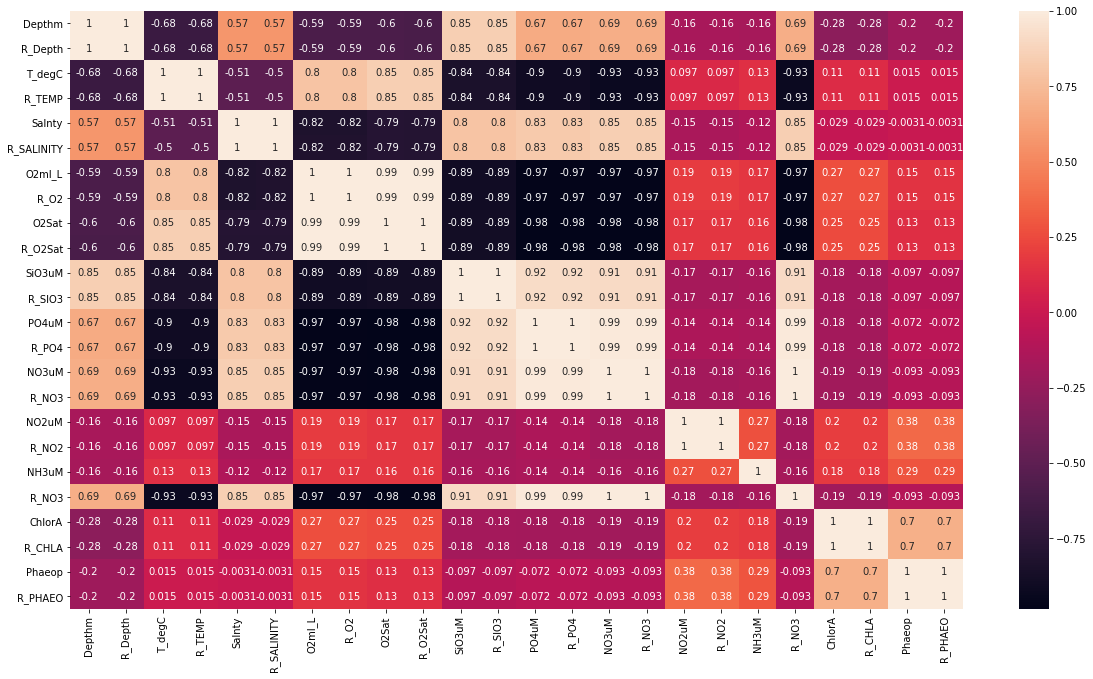

In [ ]:
# selecting features that might show high multicollinearity

df_multi= raw_bottle[['Depthm','R_Depth', 'T_degC', 'R_TEMP', 'Salnty', 'R_SALINITY', 'O2ml_L', 'R_O2',
                     'O2Sat', 'R_O2Sat', 'SiO3uM', 'R_SIO3', 'PO4uM', 'R_PO4', 'NO3uM', 'R_NO3', 'NO2uM', 'R_NO2',
                     'NH3uM', 'R_NO3', 'ChlorA', 'R_CHLA', 'Phaeop', 'R_PHAEO']]

# using heatmap

plt.figure(figsize=(20,11))
sns.heatmap(df_multi.corr(), annot= True)

In [ ]:
# selecting the relevant features. Features dropped ranged from categorical varibles (having no relevant info to the prediction
# of salinity) to reported data like R_Depth and its likes (e.g: Depthm== R_Depth)

new_bottle= raw_bottle[['T_degC', 'Depthm', 'Salnty', 'O2ml_L', 'STheta', 'O2Sat', 'PO4uM', 'SiO3uM', 'NO2uM', 'NO3uM', 'NH3uM',
             'ChlorA', 'Phaeop', 'LightP', 'R_SIGMA', 'R_SVA', 'R_DYNHT', 'R_PRES']]
new_bottle.head(3)

,T_degC,Depthm,Salnty,O2ml_L,STheta,O2Sat,PO4uM,SiO3uM,NO2uM,NO3uM,NH3uM,ChlorA,Phaeop,LightP,R_SIGMA,R_SVA,R_DYNHT,R_PRES
0,10.50,0,33.440,NaN,25.649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.64,233.0,0.00,0
1,10.46,8,33.440,NaN,25.656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.65,232.5,0.01,8
2,10.46,10,33.437,NaN,25.654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.65,232.8,0.02,10


In [ ]:
# shape of new_dataset (18 columns selected from 74)

new_bottle.shape

(864863, 18)

In [ ]:
# check for missing values. 

new_bottle.isnull().sum()

T_degC      10963
Depthm          0
Salnty      47354
O2ml_L     168662
STheta      52689
O2Sat      203589
PO4uM      451546
SiO3uM     510772
NO2uM      527287
NO3uM      527460
NH3uM      799901
ChlorA     639591
Phaeop     639592
LightP     846212
R_SIGMA     52856
R_SVA       52771
R_DYNHT     46657
R_PRES          0
dtype: int64

In [ ]:
# replacing the missing values with the mean of the observed variables. Apart from Depthm and R_PRES, others have missing values

cols= ['T_degC', 'Depthm', 'Salnty', 'O2ml_L', 'STheta', 'O2Sat', 'PO4uM', 'SiO3uM', 'NO2uM', 'NO3uM', 'NH3uM',
             'ChlorA', 'Phaeop', 'LightP', 'R_SIGMA', 'R_SVA', 'R_DYNHT', 'R_PRES']

new_bottle[cols]= new_bottle[cols].fillna(new_bottle.mean())

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [ ]:
# check for missing values

new_bottle.isnull().sum()

T_degC     0
Depthm     0
Salnty     0
O2ml_L     0
STheta     0
O2Sat      0
PO4uM      0
SiO3uM     0
NO2uM      0
NO3uM      0
NH3uM      0
ChlorA     0
Phaeop     0
LightP     0
R_SIGMA    0
R_SVA      0
R_DYNHT    0
R_PRES     0
dtype: int64

In [ ]:
print(new_bottle.shape)
new_bottle

(864863, 18)


,T_degC,Depthm,Salnty,O2ml_L,STheta,O2Sat,PO4uM,SiO3uM,NO2uM,NO3uM,NH3uM,ChlorA,Phaeop,LightP,R_SIGMA,R_SVA,R_DYNHT,R_PRES
0,10.500,0,33.44000,3.392468,25.649000,57.103779,1.564747,26.606587,0.042316,17.302247,0.084877,0.450185,0.198553,18.356509,25.64000,233.000000,0.000,0
1,10.460,8,33.44000,3.392468,25.656000,57.103779,1.564747,26.606587,0.042316,17.302247,0.084877,0.450185,0.198553,18.356509,25.65000,232.500000,0.010,8
2,10.460,10,33.43700,3.392468,25.654000,57.103779,1.564747,26.606587,0.042316,17.302247,0.084877,0.450185,0.198553,18.356509,25.65000,232.800000,0.020,10
3,10.450,19,33.42000,3.392468,25.643000,57.103779,1.564747,26.606587,0.042316,17.302247,0.084877,0.450185,0.198553,18.356509,25.64000,234.100000,0.040,19
4,10.450,20,33.42100,3.392468,25.643000,57.103779,1.564747,26.606587,0.042316,17.302247,0.084877,0.450185,0.198553,18.356509,25.64000,234.000000,0.040,20
5,10.450,30,33.43100,3.392468,25.651000,57.103779,1.564747,26.606587,0.042316,17.302247,0.084877,0.450185,0.198553,18.356509,25.65000,233.500000,0.070,30
6,10.450,39,33.44000,3.392468,25.658000,57.103779,1.564747,26.606587,0.042316,17.302247,0.084877,0.450185,0.198553,18.356509,25.65000,233.000000,0.090,39
7,10.240,50,33.42400,3.392468,25.682000,57.103779,1.564747,26.606587,0.042316,17.302247,0.084877,0.450185,0.198553,18.356509,25.68000,231.000000,0.110,50
8,10.060,58,33.42000,3.392468,25.710000,57.103779,1.564747,26.606587,0.042316,17.302247,0.084877,0.450185,0.198553,18.356509,25.71000,228.500000,0.130,58
9,9.860,75,33.49400,3.392468,25.801000,57.103779,1.564747,26.606587,0.042316,17.302247,0.084877,0.450185,0.198553,18.356509,25.80000,220.100000,0.170,75


In [ ]:
new_bottle.shape

(864863, 18)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_tools.py:308: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_tools.py:308: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_tools.py:314: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed 

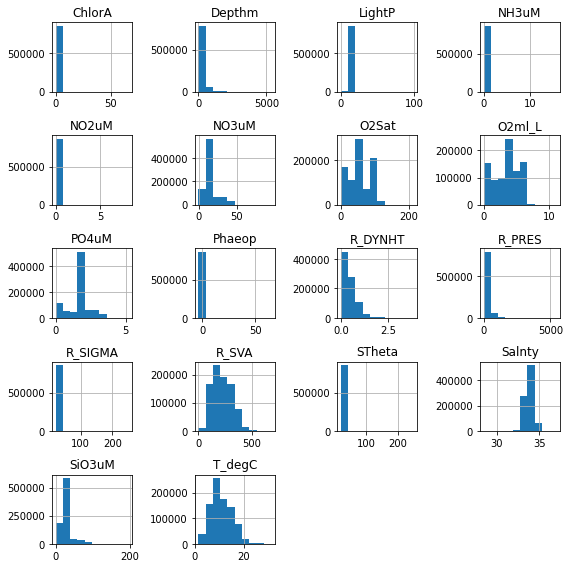

In [ ]:
# Data Visualization to check for normality

fig = plt.figure(figsize = (8,8))
ax = fig.gca()
new_bottle.hist(ax = ax)
plt.tight_layout()

# There is some degree of normality within some features and the target variable (Salnty)
# while some features showed signs of being otherwise. I will Proceed without fixing for now**

In [ ]:
# Splitting datasets into train and test sets

X= new_bottle[['T_degC', 'Depthm', 'O2ml_L', 'STheta', 'O2Sat', 'PO4uM', 'SiO3uM', 'NO2uM', 'NO3uM', 'NH3uM',
             'ChlorA', 'Phaeop', 'LightP', 'R_SIGMA', 'R_SVA', 'R_DYNHT', 'R_PRES']]

y= new_bottle['Salnty']

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2, random_state= 1)

print ('X_train_shape: {}'. format(X_train.shape))
print ('y_train_shape: {}'. format(y_train.shape))
print ('X_test_shape: {}'. format(X_test.shape))
print ('y_test_shape: {}'. format(y_test.shape))

X_train_shape: (691890, 17)
y_train_shape: (691890,)
X_test_shape: (172973, 17)
y_test_shape: (172973,)


In [ ]:
# Normalizing X_train & X_test using MinMaxScaler

scaler= MinMaxScaler()

# fit_transforming X_train

norm_X_train= scaler.fit_transform(X_train)
norm_X_train

array([[0.1989899 , 0.05606429, 0.13913824, ..., 0.19985359, 0.15463918,
        0.05533162],
       [0.26430976, 0.02336012, 0.30542802, ..., 0.30937042, 0.09278351,
        0.02308538],
       [0.1047138 , 0.16819286, 0.30542802, ..., 0.32289739, 0.11127914,
        0.1663613 ],
       ...,
       [0.50505051, 0.0186881 , 0.30542802, ..., 0.41918009, 0.09020619,
        0.01832173],
       [0.08787879, 0.18688096, 0.30542802, ..., 0.11625183, 0.33762887,
        0.18468303],
       [0.14545455, 0.11324986, 0.03231598, ..., 0.14685212, 0.23969072,
        0.11176255]])

In [ ]:
# Transforming X_test

norm_X_test= scaler.transform(X_test)
norm_X_test

array([[0.4003367 , 0.00654083, 0.5951526 , ..., 0.41888726, 0.03092784,
        0.00641261],
       [0.52188552, 0.01364231, 0.41561939, ..., 0.48125915, 0.06958763,
        0.01337486],
       [0.31919192, 0.01382919, 0.3491921 , ..., 0.36178624, 0.05927835,
        0.01355808],
       ...,
       [0.27811448, 0.0186881 , 0.23159785, ..., 0.27891654, 0.06958763,
        0.01832173],
       [0.18552189, 0.07419174, 0.10682226, ..., 0.1920937 , 0.2371134 ,
        0.0731037 ],
       [0.43838384, 0.01289479, 0.5529623 , ..., 0.45929722, 0.06185567,
        0.01264199]])

In [ ]:
# Case1: using Linear Regression

reg= LinearRegression()
reg.fit(norm_X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# prediction 

y_pred= reg.predict(norm_X_test)
df1 = pd.DataFrame({'Actual_1': y_test, 'Predicted_1': y_pred})
df1

,Actual_1,Predicted_1
162807,33.41000,33.424291
22398,33.87000,33.846594
136704,33.36000,33.475292
61221,33.35000,33.415011
687320,33.31200,33.401440
618038,33.29100,33.328830
222008,34.07000,33.955615
577121,33.99300,33.965074
378685,34.50800,34.248585
350675,34.48000,34.597708


In [ ]:
# R-squared

r2= r2_score(y_test, y_pred)
round(r2, 3)

0.873

In [ ]:
# MSE 

mse= mean_absolute_error(y_test, y_pred)
round(mse, 3)

0.089

In [ ]:
# case 2: Using Decision Trees

reg_dec= DecisionTreeRegressor(max_depth= 2)
reg_dec.fit(norm_X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
# prediction 

y_pred2= reg_dec.predict(norm_X_test)
df_dec = pd.DataFrame({'Actual_2': y_test, 'Predicted_2': y_pred2})
df_dec

,Actual_2,Predicted_2
162807,33.41000,33.364635
22398,33.87000,33.664682
136704,33.36000,33.664682
61221,33.35000,33.664682
687320,33.31200,33.664682
618038,33.29100,33.364635
222008,34.07000,34.098255
577121,33.99300,34.098255
378685,34.50800,33.664682
350675,34.48000,34.333890


In [ ]:
# R-squared

r2= r2_score(y_test, y_pred2)
round(r2, 3)

0.585

In [ ]:
# MSE 

mse= mean_absolute_error(y_test, y_pred2)
round(mse, 3)

0.198

In [ ]:
# case 3: Using cross validation

cross_val_score(reg, X, y, cv=10, scoring = 'r2').mean()

0.4960722551131392

In [ ]:
# r-square

reg.score(norm_X_train, y_train)

0.8703832989653233

**BUILDING COMPONENT**

In [ ]:
!pip3 install kfp --upgrade --user

Requirement already up-to-date: kfp in /root/.local/lib/python3.6/site-packages (1.0.3)


In [ ]:
!which dsl-compile

In [ ]:
# Import Kubeflow SDK
import kfp
import kfp.dsl as dsl
import kfp.components as comp

In [ ]:
# where the outputs are stored
out_dir = '/content/drive/My Drive/Colab Notebooks/data'

In [ ]:
def train(data_path, model_file):
    
    import pickle
    import sys, subprocess;
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'pandas==0.23.4'])
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'scikit-learn==0.22'])
    import numpy as np
    import pandas as pd
    import tensorflow as tf
    from tensorflow.python import keras
    # splitting the data
    from sklearn.model_selection import train_test_split
    # Standardization - feature scaling
    from sklearn.preprocessing import StandardScaler
    # data encoding
    from sklearn.preprocessing import LabelEncoder
    
    
    # Define the model using Keras.
    classifier = keras.models.Sequential(name = "Salinity")
    classifier.add(keras.layers.Dense(units =6, activation='relu'))
    classifier.add(keras.layers.Dense(units =6, activation='relu'))
    classifier.add(keras.layers.Dense(units =1, activation='sigmoid'))

    ##classifier.summary()

    classifier.compile(optimizer = 'adam', loss='binary_crossentropy', metrics =['accuracy'])

    # Run a training job with specified number of epochs
    classifier.fit(norm_X_train, y_train, batch_size=10 , epochs=50 )

    #Evaluate the model and print the results
    test_loss, test_acc = classifier.evaluate(norm_X_test,  y_test, verbose=0)
    print('Test accuracy:', test_acc)

    #Save the model to the designated 
    classifier.save(f'{data_path}/{model_file}')

    #Save the test_data as a pickle file to be used by the predict component.
    with open(f'{data_path}/test_data', 'wb') as f:
        pickle.dump((X_test,  y_test), f)

In [ ]:
classifier = train(out_dir, "model")

Epoch 1/50
69189/69189 [==============================] - 50s 720us/step - loss: -232748640.0000 - accuracy: 0.0000e+00
Epoch 2/50
69189/69189 [==============================] - 52s 759us/step - loss: -2990402048.0000 - accuracy: 0.0000e+00
Epoch 3/50
69189/69189 [==============================] - 45s 647us/step - loss: -12155247616.0000 - accuracy: 0.0000e+00
Epoch 4/50
69189/69189 [==============================] - 45s 645us/step - loss: -31645722624.0000 - accuracy: 0.0000e+00
Epoch 5/50
69189/69189 [==============================] - 47s 673us/step - loss: -65390473216.0000 - accuracy: 0.0000e+00
Epoch 6/50
69189/69189 [==============================] - 45s 645us/step - loss: -117322260480.0000 - accuracy: 0.0000e+00
Epoch 7/50
69189/69189 [==============================] - 45s 645us/step - loss: -191360286720.0000 - accuracy: 0.0000e+00
Epoch 8/50
69189/69189 [==============================] - 45s 644us/step - loss: -291003990016.0000 - accuracy: 0.0000e+00
Epoch 9/50
69189/69189 [

In [ ]:
def predict(data_path, model_file):
    
    import pickle
    import tensorflow as tf
    from tensorflow import keras
    import numpy as np
    
    # Load the saved Keras model
    classifier = keras.models.load_model(f'{data_path}/{model_file}')

    # Load and unpack the test_data
    with open(f'{data_path}/test_data','rb') as f:
        test_data = pickle.load(f)
    # Separate the X_test from y_test.
    X_test,  y_test = test_data

    # make predictions.
    y_pred = classifier.predict(X_test)

    # create a threshold
    y_pred=(y_pred>0.5)
    
    with open(f'{data_path}/result.txt', 'w') as result:
        result.write(" Prediction: {}, Actual: {} ".format(y_pred,y_test.astype(np.bool)))
    
    print('Prediction has be saved successfully!')

In [ ]:
predict(out_dir, "model")

Prediction has be saved successfully!


In [ ]:
# Create train and predict lightweight components.
train_op = comp.func_to_container_op(train , base_image = "tensorflow/tensorflow:latest-gpu-py3")
predict_op = comp.func_to_container_op(predict , base_image = "tensorflow/tensorflow:latest-gpu-py3")

In [ ]:
#Create a client to enable communication with the Pipelines API server.
client = kfp.Client()

In [ ]:
# Define the pipeline
@dsl.pipeline(
   name='Water Salinity Pipeline',
   description='An ML pipeline that performs water salinity model training and prediction.'
)

# Define parameters to be fed into pipeline
def salinity_container_pipeline(
    data_path: str,
    model_file: str
):
    
    # Define volume to share data between components.
    vop = dsl.VolumeOp(
    name="create_volume",
    resource_name="data-volume", 
    size="1Gi", 
    modes=dsl.VOLUME_MODE_RWO)
    
    # Create training component.
    salinity_training_container = train_op(data_path, model_file) \
                                    .add_pvolumes({data_path: vop.volume})

    # Create Churn prediction component.
    salinity_predict_container = predict_op(data_path, model_file) \
                                    .add_pvolumes({data_path: churn_training_container.pvolume})
    
    # Print the result of the prediction
    salinity_result_container = dsl.ContainerOp(
        name="print_prediction",
        image='library/bash:4.4.23',
        pvolumes={data_path: churn_predict_container.pvolume},
        arguments=['cat', f'{data_path}/result.txt']
    )

In [ ]:
DATA_PATH = '/mnt'
MODEL_PATH='salinity_classifier.h5'

In [ ]:
pipeline_func = salinity_container_pipeline

In [ ]:
experiment_name = 'water_salinity_kubeflow'
run_name = pipeline_func.__name__ + ' run'

arguments = {"data_path":DATA_PATH,
             "model_file":MODEL_PATH}

# Compile pipeline to generate compressed YAML definition of the pipeline.
kfp.compiler.Compiler().compile(pipeline_func,  
  '{}.zip'.format(experiment_name))

# Submit pipeline directly from pipeline function
run_result = client.create_run_from_pipeline_func(pipeline_func, 
                                                  experiment_name=experiment_name, 
                                                  run_name=run_name, 
                                                  arguments=arguments)